# Description

## Goal

Develop a unified community DA system for research and operations

## Partners

* NASA/GMAO
* NOAA/NWS
* NOAA/NESDISS
* NOAA/OAR
* NRL (Naval Research Lab)
* Oceanographer of the Navy
* US Air Force

## Components

* Models/Grids (reanalysis)
    * Atmosphere
    * Ocean
    * Land
    * Regional
    * Global
    * Toy models
* Observations
    * Past
    * Current
    * Future
* Solvers
    * Variational
    * EnKF
    * Hybrid
* In this context. OOPS refers to "Object Oriented Prediction System" a C++ implemented weather forecasting system developed by ECMWF

# Data Assimilation Issues

* Will existing systems be able to scale on future highly parallel machine architectures?
* Scientific/technical challenges to coupled DA
    * NGGPS (Next Generation Global Prediction System)
    * ESPC (Earth System Prediction Capability)


# JEDI Architecture

## Context surrounding JEDI

JEDI is the section with the pink boxes (pink represents DA processes) in the following figure. Figure is from a UCAR internal document titled "System Architecture for Operational Needs and Research Collaborations" and dated March 31, 2017.

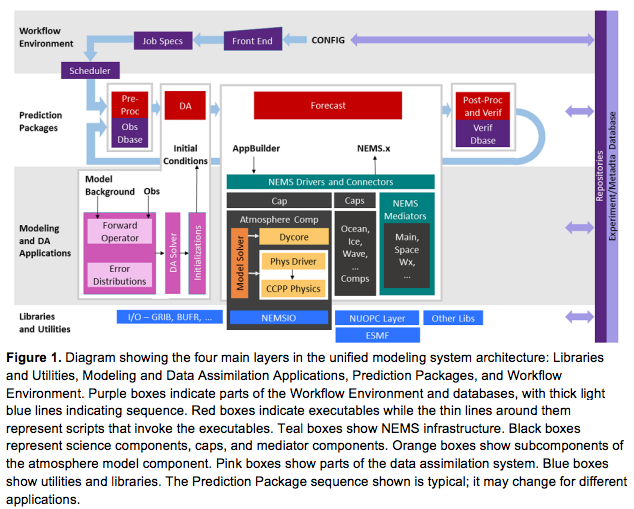

## JEDI Design

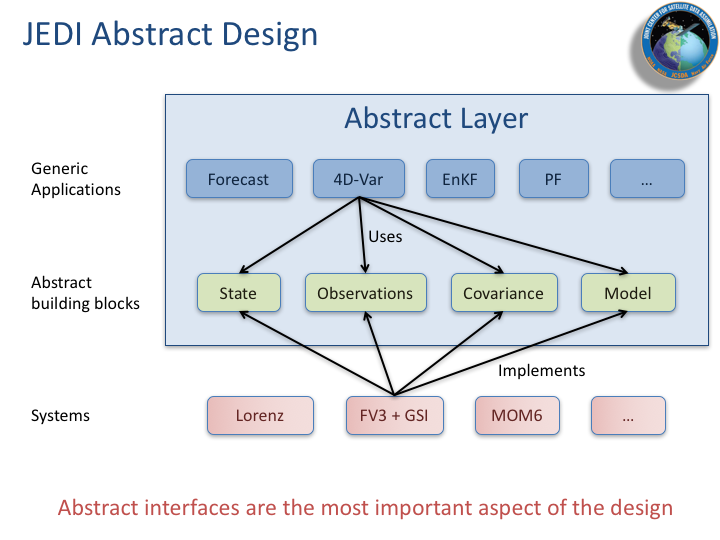

# Notes from 12/13/17 meeting with Yannick

Compute mismatch between forecast and observations
* Observation operator
* Model fields --> compute what observation would be
    * Wind, T are easy --> interpolate to location of obs
    * Satellite, Radar dBZ are complex
        * model quantities --> radar obs (simulated)

Two active items for obs operators
* Temperatures from radiosondes
* Radiance measurements from satellites
    * Satellite looks from top down
    * Surface interaction
    * Radiative transfer model, CRTM

Two steps for obs operators
* Model field --> interpolate to location that saellite is observing
    * Form profile: T, RH, etc.
* Call CRTM to get simulated radiance
* Compare simulated obs to actual obs

Mismatch between actual obs and simulate obs is express as a cost function
* DA is like a big optimization problem
* Do this 4 times a day (every 6 hours)
    * Sim obs, obs --> cost function --> adjust initial conditions for model --> simulate 6 more hours --> repeat

Two stage DA process
* First stage is model dependent
    * Specific grid
    * Interpolate step to get alignment between model and satellite locations
* Second stage is model independent
    * Common grid/locations
    * Cost function, adjust initial conditions

Collection of obs operators is also know as "forward ops"
* Everyone develops their own, we are trying to organize into a common set
* UFO --> Unified Forward Operators

Obs come in several formats
* Location, dae, time, which sensor, frequency, channels
* Want an API for access to these
    * Shared among different centers

100,000,000 obs operators
* Organize
* Process
* Etc.

Obs operators
* Meta data
* Access
* Two issues
    * Starndarize view into obs ops
    * Efficient API to access obs ops

# JEDI obs operators meeting 12/13/17

Update since last Code Sprint

Link GFS with UFO

Singularity, Docker

Verify code runs on disparate machines, different platforms
* Either new person of shared between Xin, Steve and Mark
* Trying to get funds for a new person

Locations linked into UFO

Radiances - checking mismatches

Anna
* Inputs to CRTM
    * Issues with effective radius, and getting it out of model
* Issue with profiles
    * Model doesn't go to TOA as represented in CRTM
    * Need to fill in upper section of profile
    * Preprocessing step that goes into CRTM

Bryan
* Geovals --> interpolated values (UFO)
    * T, RH, Ozone, SST, etc.
    * Array in geovals holds these
* Docker, FV3 build works using Intel compiler
    * Copy to "Thayer" and won't compile, could be new compiler is stricter than old version

Next steps
* Next meeting in January, after AMS
* Need to acquire, get access to, Intel compilers


# JEDI Interpolation meeting, 12/14/17

Jim Rosinski (Software Engineer)

Compile issues with CRTM

# JEDI Interpolations meeting 12/20/17

GitLFS
* Large file storage
* Compare with Google Drive, other cloud systems

Issues
* FV3 only compiles and runs on one machine with one compiler
* Tests
    * Need a short serial test, quick check for debug
    * Need a common initialization for all models

ecbuild
* Layer on top of CMake
* Macros

Latets CMake is version 3
* Free book online for version 2

Plan is to get rid of ecbuild and replace with CMake version 3
* New features in CMake version 3 cover what is being used from ecbuild

eckit
* C++ utilities
* Overlap with Boost
* Using this for testing framework
    * Look at Google, etc.
    * Mark will work on this



# Meeting with Yannick, 12/20/17

## Data Assimilation

Cost Function

$$ J(x_0) = \left\{\sum_{i=0}^{N} [H(x_i) - y_i]^T R^{-1} [H(x_i) -y_i]\right\} + (x_o - x_b)^T B^{-1} (x_o - X_b) $$

Where:
* $x_b$ is the background (model forecast)
* $x_o$ is the observation
* $H(x)$ is the observation operator (coversion of model output into observation data)
* $R$ is the observation covariance matrix (observation error)
* $B$ is the background covariance matrix (background error)
* $x_i$ is model state at time $t_i$
    * $x_i = M_{t_0 \rightarrow t_i}$

Trying to minimize the cost function (this is what GSI does).

UFO does the observation operator function ($H(x)$)

## Terminology (from JEDI requirements doc)
* Priors is same as background
* Innovation (new info, new obs), initial discrepancy of obs and background ($H(x_b) - y$)
* Unstructured grid, example is locations of ground stations
* Coupled DA
    * Atmosphere
    * Ocean
    * Sea Ice
    * Land surface
    
    * Can do cost function analysis on each of the above
    * Coupled DA is simultaneously processing all or subset of above
* One-way coupling
    * Sea $\rightarrow$ Atmos
    * Atmos $\rightarrow$ Sea
    * Typically not that useful, but used for wind effects on water waves (i.e., on a naturally one-way process)
* Two-way coupling
    * Surface $\leftrightarrow$ Atmos
* Observation thinning
    * Too many observations, keep an arbitrary selection, e.g. every 100th
    * Lots of obs close to each other
        * Not independent samples
        * Hard to deal with correlations, come up with a representative value
* Superobbing
    * Many spatially local obs, average together
        * Difficult to evaluate error
    * Popular in the US, not so much in Europe
    * Keeping a subset of obs (thinning) is typically easier to manage
* Localization
    * EnKF (Ensemble Kalman Filter) technique
    * Ensemble forecast, look for linear combination of members of ensemble
        * Millions of obs, too big computationally
    * Look for linear combination on local spatial scale
        * Reduce size of set, computable
* Inflation
    * Related to Localization
    * EnKF
    * After repeating DA process, ensembles tend to look more alike (collapse)
    * Inflation is a process to inject differences into ensembles (opposite of collapse)
* Out-of-core computation
    * Fancy term for swapping memory
    * Examples given in the JEDI requirements document is not typical
* CGAL
    * "Computational Geometry Algorithms Library"
    * C++ library
    * Geometric algorithms
        * Veronoi diagrams
        * Triangulation
        * Surface and volume mesh generation
        * Geometry processing
        * Etc.
* Boost
    * C++ library
    * Utilities
    * boost.org
    * In our case, used for testing framework
* TensorFlow
    * Python library
    * Machine learning
    * Big data
    * Could be used as data structure for obs.
        * But, Fortran to Python is awkward
        * Mabye go to underlying C++, but only if clean C++ API
* BUFR
    * WMO format for exchanging obs
        * Old, before internet
    * All satellite data arrives in this format
    * Different format for each obs

## Test stragey
* We want to use all types of tests
    * Unit
    * Integration
    * System
    * Acceptance
* The usage of "unit test" in the requirements doc generally refers to all types of testing

## UFO
* UFO is $H(x)$ operator in cost function
    * $x$ is state of atmosphere, model fields
    * Each lab has their own way of representing $x$
    
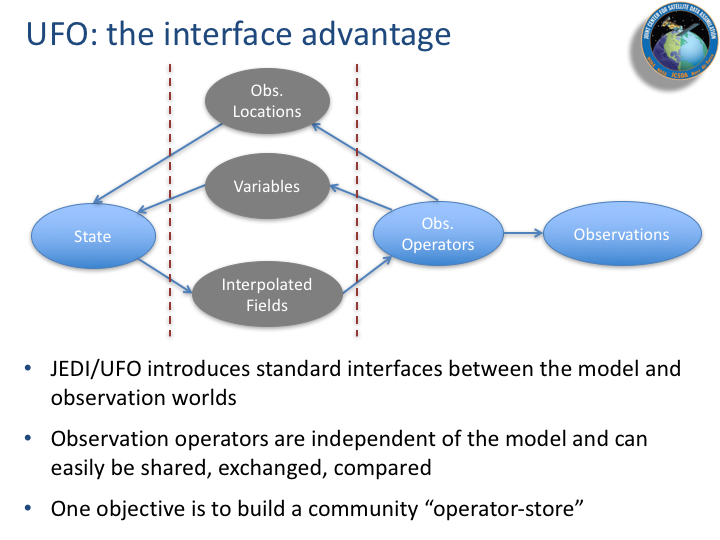

   ### Notes on above diagram
    * Observation Operators
        * CRTM
        * Interpolation to standard vertical levels is done here for now
    * Interpolated fields
        * Geovals
        * Abstracted
        * Profile (p, T, RH, etc.)
    * Observations
        * Satellite, sondes, radar, etc.
        * Metadata
            * Channels
            * Frequency
            * Etc.

## DA Flow
* DA process has two steps
    1. Interpolation
    1. Scientific application

    ### Example
    
    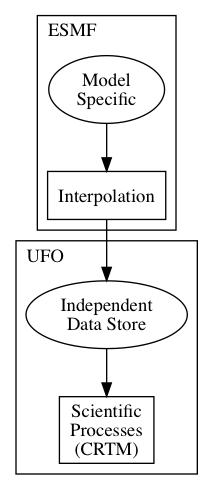

        * ESMF is interpolation step
            * EMSF - Earth System Modeling Framework
            * Large system
            * Fortran
            * Monolithic structure
                * Makes it difficult to use
            * Be nice to break this up into modules
        * UFO is scientific application step


# Meeting with Clara Draper, 12/20/17

* BUFR to netcdf conversion
    * Jeff Whitaker
    * Python code
        * JEDI_conv_bufr2nc_2D.py
            * Sample input BUFR: prebufr.gdas.2016030406
        * JEDI_amsu_bufr2nc.v8.py
            * Sample input BUFR: 1bamua.gdas.2016030406
    * Python module, py-ncepbufr
        * Call Fortran library routines for accessing BUFR files
        * Stored on GitHub
            * jswhit/py-ncepbufr
* ASMU --> Advanced Sensing Microwave Unit
* Conventionals --> sounding values (p, T, RH, etc.)
* BUFR
    * Self describing binary file
    * Query tables to find variables
        * Record --> messages --> observations
* Currently, GSI reads in data directly from BUFR files
* Want to have GSI read in abstracted observational data with common API
* The python conversion scripts are prototypes of the abstracted observational data
    * Clara also created netcdf reader for GSI
    * Currently have one netcdf file for each variable
        * Want to move to one file for each instrument/obs set ("Observation Type")
    * BUFR --> netcdf --> GSI --> GSI output
        * GSI output produced from netcdf (new) flow should match (bit compatible) with current GSI output
    * Python scripts are probably heavier weight than what is necessary
    * Scott Gregory can help with questions
* Theia --> server where examples are stored
* Clara will be out next week and at AMS


# Meeting with Yannick, 12/22/17

## IODA
* Interface for Observational Data Access
* Common view API
* Use cases
    * Long term archive of obs data
        * Research use
        * Large capacity, permanent storage (tape?)
        * Do not require fast access
    * Data for last 6 hours on store
        * Fast access
        * Operational mode
        * Research/Development testing
    * In-memory data structure
        * HPC system
        * Distributed across multiple processes
        * Fast access
    * Plotting, statistics
        * Desktop/Laptop
        * Read from store into memory
        * Small process so can do with desktop, laptop
* Fortran, C++, Python
* Incoming data is very diverse
    * Aircraft
    * Satellite
    * Radar
    * Etc.
* Need generic format, UFO is an example of this
* GitHub repository --> UCAR/ioda
* This is what I will own eventually
* Take a look
    * Uses netcdf from bufr2nc

## ODB API
* ODB --> Observational DataBase
* ECMWF developed
* Open source
* If we develop something new, it has to be better than ODB API
    * Either ODB is a candidate for our solution
    * Or it is a model of what we want
* Core is written in C, C++
* API for Fortran, C++ and Python
* netcdf
* ~300,000 lines of code
* Good design and implementation
    * Been in production for a while
    * Uses a variant of SQL
    * ODB1
        * Fully distributed (HPC)
        * Efficient
        * Not open source
    * ODB2
        * Fully distributed
        * Not as efficient as ODB1
        * Open source

## TensorFlow
* Python
* Machine learning
* Optimization features that may be applicable to the DA cost function minimization problem
* People will want to access data through TensorFlow
* Learn how access would work
* Learn basic concepts of TensorFlow

## UFO
* Look at
    * ufo_radiance_mod.F90
    * ufo_radiosonde_mod.F90
    
    * Look at C++ wrappers for these too
    * These are examples of how the access to observational data is envisioned

## Books for group
* CMake
* "Object Oriented Software Construction"
* Tom buy a few copies for the group

# JEDI Interpolations meeting, 1/17/18
* Trying to integrate FV3 with JEDI
* Got FV3 to compile and have tests running
    * Lots of test failures
    * Dot product fails
        * Maybe including halo and double counting
    * FV3 must run in parallel (at least 6 processes)
        * Could try with no halo, but that will mess up the model
    * Working on nasa-discover-\* branches in code
* Interpolations, UFO
    * QG
    * Lawrence
* Events
    * OOPS training
        * 1 week
        * For devlopers
        * Cover relevant topics in C++
        * Cover object oriented design
    * Code sprints
        * Potential topics
            * Interpolations
            * Obs processes (QC, R matrix)
            * Obs bias correction
            * Testing
            * CRTM
                * Jacobians
            * B Matrix
            * Ocean
            * ???
* Dan Holdaway is visiting
    * Mini code sprint to get FV3 working with UFO
* Expand meeting audience in future to cover more models

# JEDI team meeting, 1/23/18
## Timeline
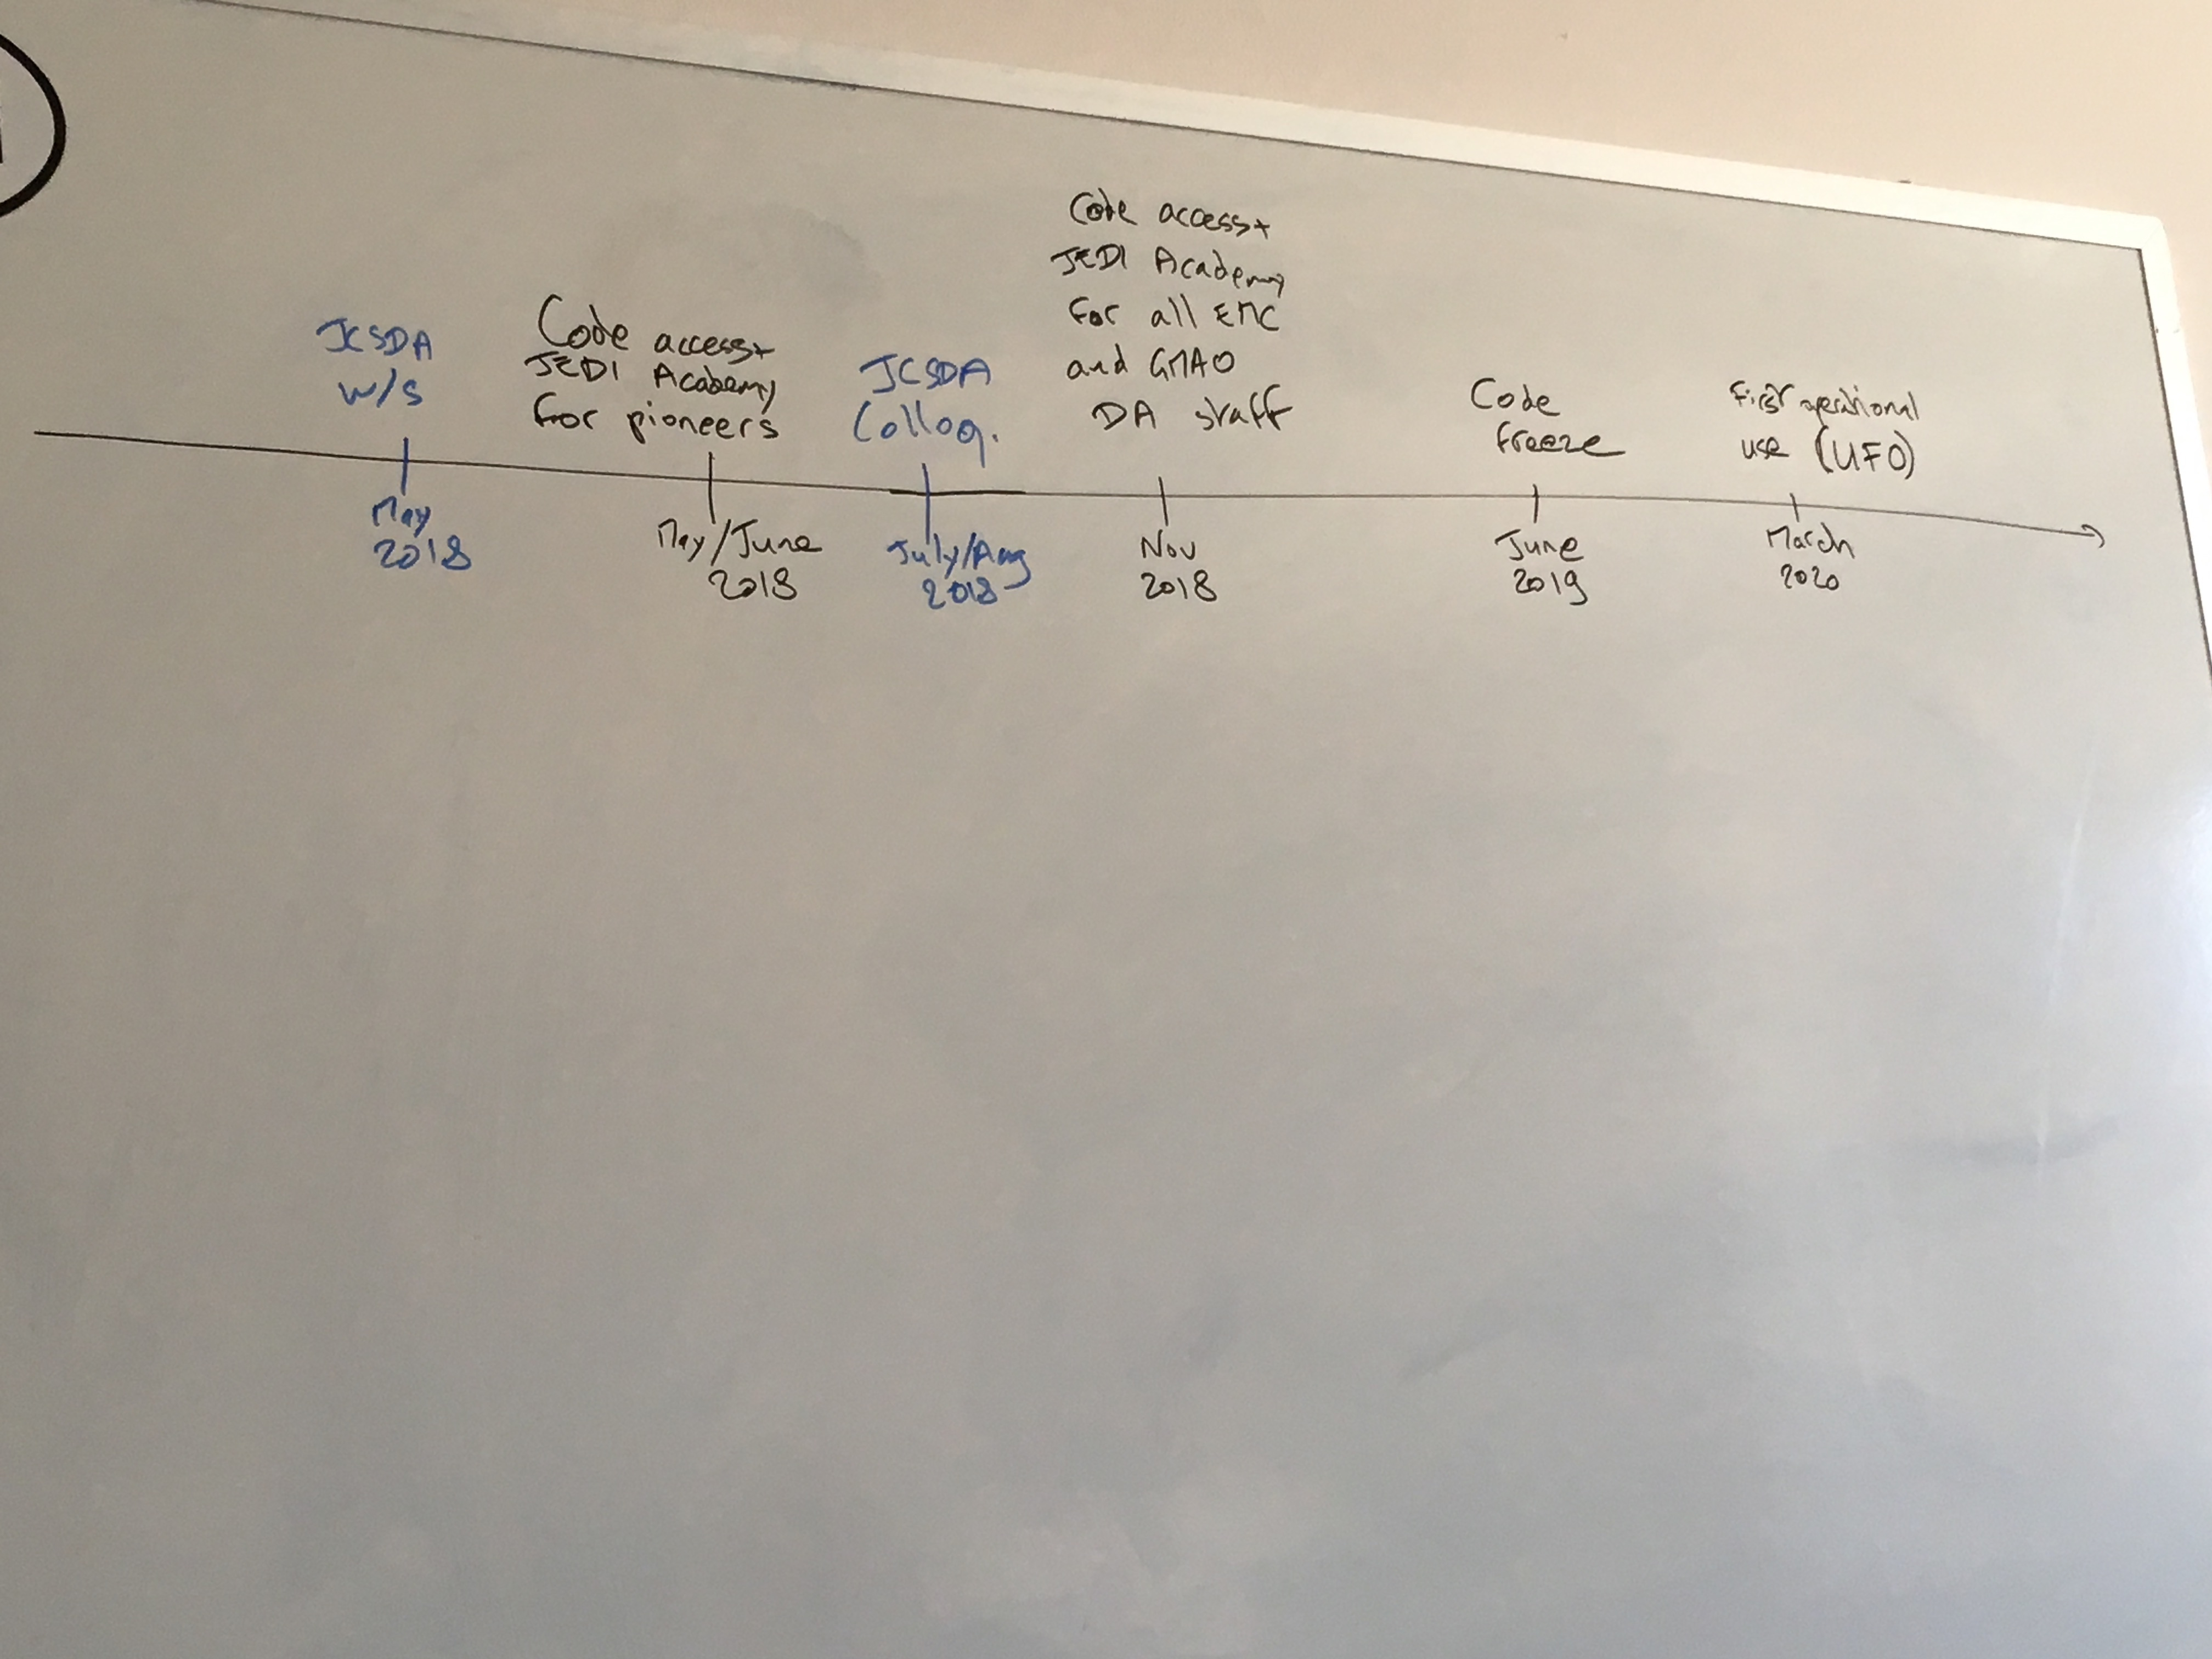

  * Textual version of timeline
      * JCSDA workshop: May, 2018
          * Boulder
      * Code access and JEDI Academy: May/June 2018
          * Boulder
          * For pioneers
      * JCSDA Colloquiem: July/Aug, 2018
          * Montana State, Bozemann
      * Code access and JEDI Academy: Nov, 2018
          * College Park
          * For all of EMC and GMAO DA staff
      * Code Freeze: June, 2019
      * UFO first operational use: March, 2020
          * UFO replaces GSI observer
          
  * EMC is Environmental Modeling Center
  * JEDI academy (black) is training we provide to scientists
  * JEDI workshop (blue) is traingin we provide to students
  * Scope will be reduced before extending delivery date
  * Black items are milestones
  * Blue items are events

## Yannick's task list
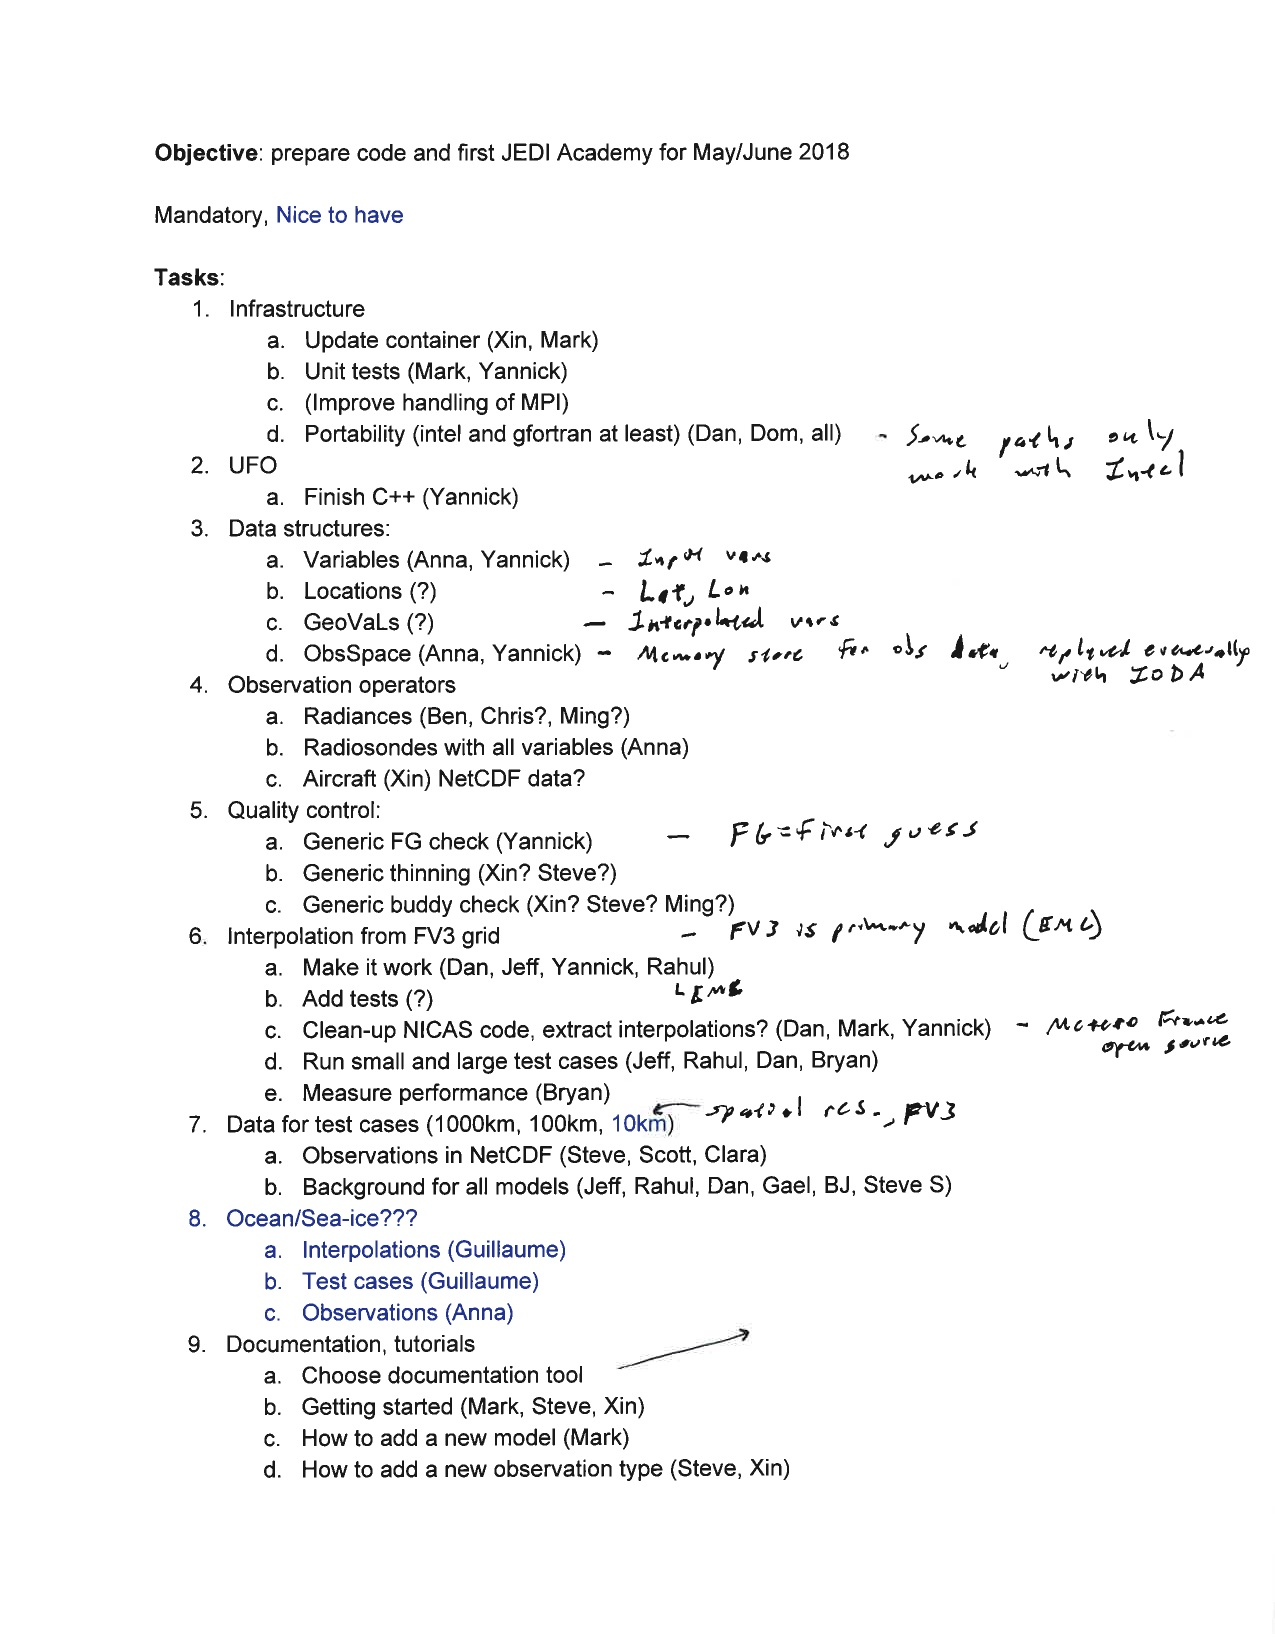
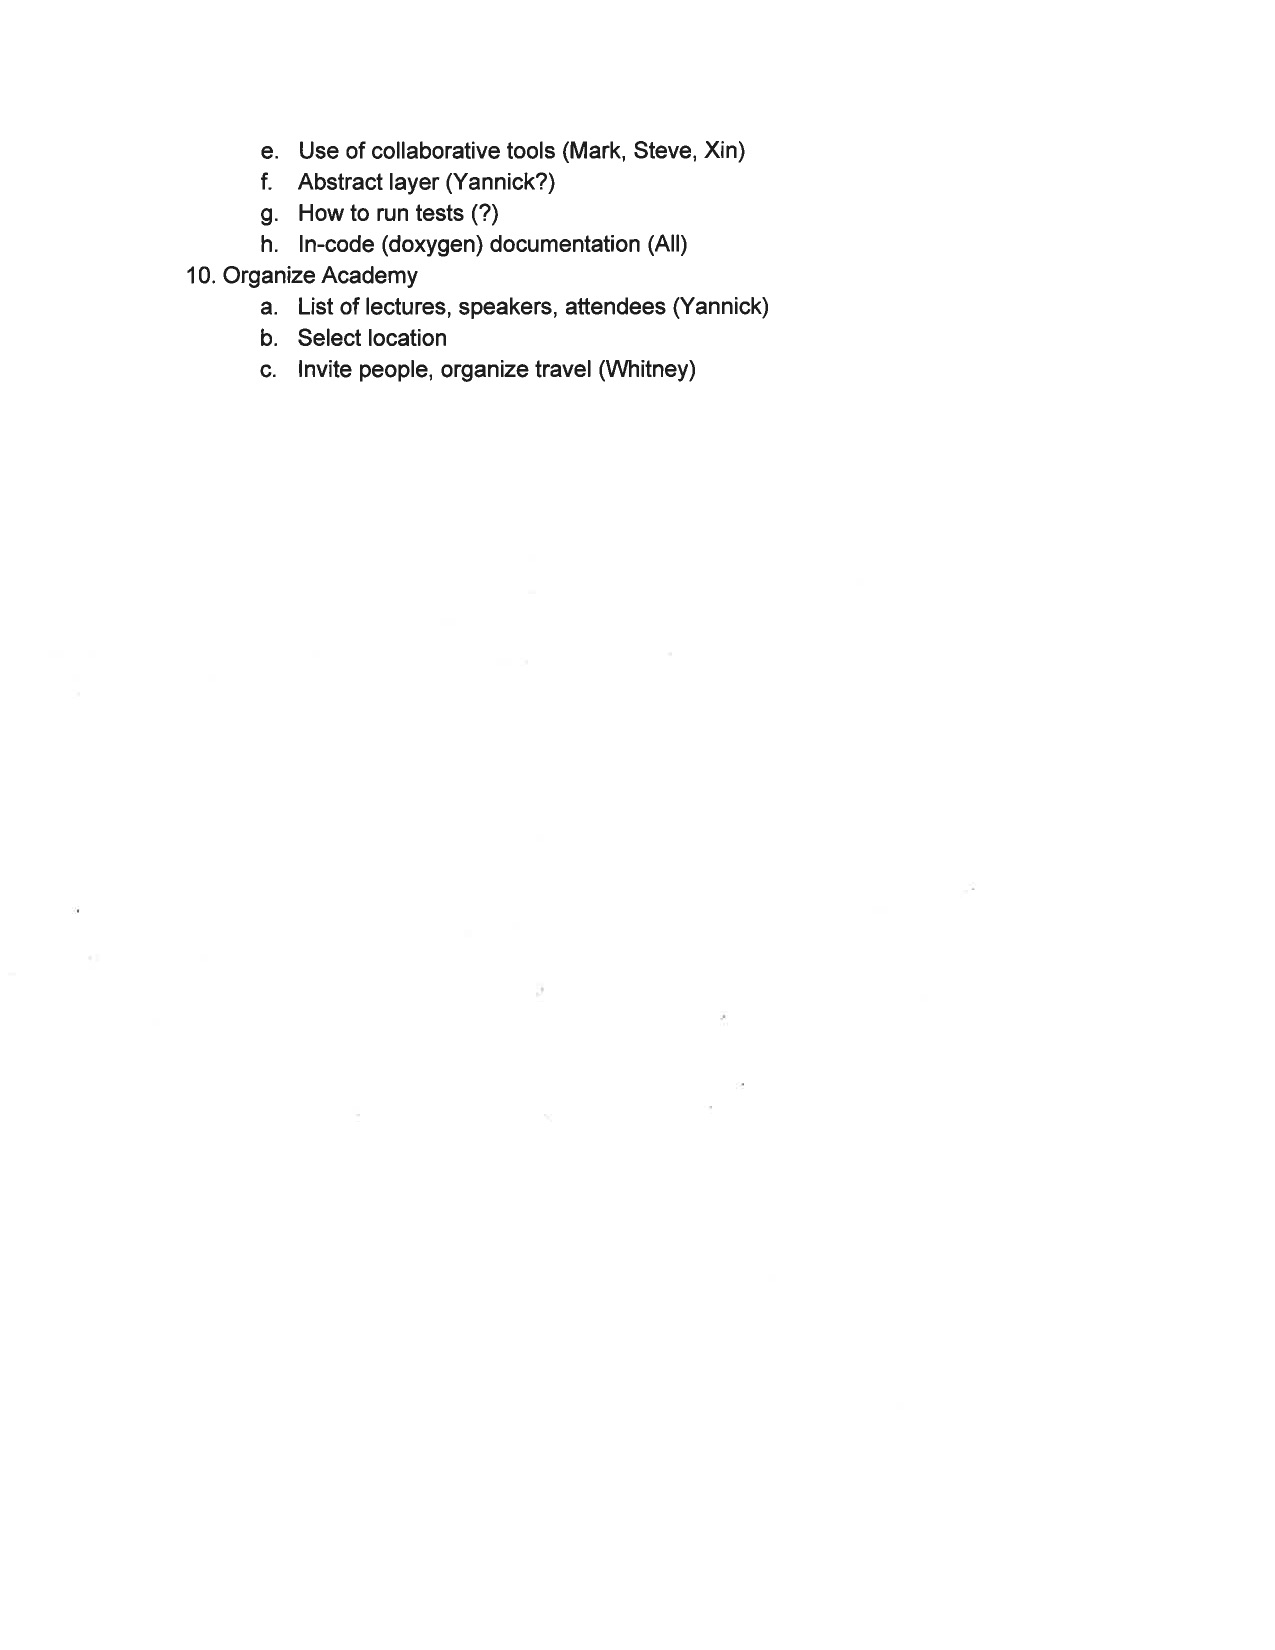

* FV3 only works with Intel Compiler
    * EMC model
    * EMC is primary user
    * Need to get working with gfortran
        * Cannot put Intel compiler inside container since it is proprietary
    * GOES5 uses FV3 dynamic core
        * This works with gfortran
    * FV3 only runs on Thiea
    * Apparently difficult to set up and use a low-res (1000km) grid
* Interpolation from FV3 grid (#6 on task list)
    * Add tests
        * Want analytic function to verity interpolation
        * Can do this with an object in C++
        * Difficult to do this in Fortran
* Help Xin with aircraft obs ops
    * Needs to convert BUFR to netCDF
* SW Methodology
    * Need to decide which tools to use
        * Put comments on each tool (pros/cons) on Wiki
    * Issue Tracking - Mark
    * Documentation - Steve
    * Continuous Integration - Xin

    * For Documentation
        * LaTex is important
            * Need example from each tool
        * Try Doxygen
            * Only used for API reference doc
            * Can it do more: man pages, website?
            * Mark: R Studio has a version called Roxygen
        * R Studio is a good example of look and feel for documentation
            * Also for how to organize and content
                * Eg, vignettes
                    * User experiences
* Need containers working on many platforms
    * Student workshop, good for making all platforms consistent
    * Want to run in Amazon Cloud (we have a UCAR account)
    * Docker and Singularity
    * Need to run a code debugger in the container
    * Cannot put proprietary software in the container
        * This is why FV3 only working with Intel is an issue
* If we feel we need training, let Yannick know
    * Eg, C++ class
* UFO interpolator doesn't work yet
    * Bypassing with GSI interpolated output for now
    * Dan is finishing up the UFO interpolation fix
* Need to get MPI working on all pieces of UFO
    * Eg, generic thinning (QC, #5 on task list) does not work with MPI
* Need to defer IODA, ODB work
    * Will do this later
    * Focus on UFO milestones, for now
    * Move IODA milestone from March, 2018 to June, 2018


# Team meeting, 1/30/18
* Team operations
    * Two GitHub repos, one public the other private
        * Develop docs, view locally from the private repo
        * Publish docs, view publicly from the public repo
    * C, C++ coding style as defined by Google
        * cpplint
    * Started a Fortran coding style doc (Yannick)
    * Will use GitHub for all JEDI (JCSDA) repositories
        * GSI (old DA system) is in BitBucket only because it is too big for GitHub
            * GSI is being obsoleted, so no need to break it up and store in GitHub
    * Add in Doxygen code, directives
* Software development tools
    * Tools/Methods that we come up with need to support mutiple projects over multiple organizations

| System | Organization |
|:------:|:------------:|
| JEDI   | UCAR         |
| WRF    | NCAR         |
| MPAS   | NCAR         |

* 
    * Doc tools: reStructuredText, Sphinx, Doxygen, ReadTheDocs
        * reStructuredText has better feature set (indexing, TOC, LaTex etc.)
        * Sphinx is easy and makes great web pages
        * ReadTheDocs is easy
            * But need to resolve the private repo connect issue
        
        * Get a Basic business version of ReadTheDocs for further investigation
            * This may help resolve the connect issue (to private repo)
    * Management tools: ZenHub
        * Trello is expensive
        * Committed to GitHub
        * Jira is difficult to use
        
        * Can we get a free version since we are a .edu (acedemic) organization?
    * Continuous integration: GoCD
        * GitHub
        * Commits trigger the "pipeline"
            * Build->Test->Package->Release
        * Organized with "agents"
            * Process that runs locally or remotely
                * Can we fire off an agent from the outside on Cheyenne?
            * Agent runs a build, or test, etc.
                * Configuration:
                    * Container or no container
                    * Number of cores
                    * Etc.
            * Can access Amazon Cloud via agent
                * What compilers are available?
        * Fill out forms (minimal script writing) to define flows
    * Workflow management: ?
        * Cylc
        * ExFlow
            * PyFlow (layer on top of EzFlow)
    * Two stages:
        * Investigation
            * Limited set of users
            * Iron out issues
        * Deployment
            * Formal presentation to all contributors
            * Training
            * May JCSDA Workshop
* UFO
    * Look at class organization

# Team meeting, 2/5/18
* Documentation
    * One solution to the inability of ReadTheDocs to connect to a private GitHub account is to obtain our own domain and publish the HTLM produced by Sphinx there.
        * May have some ownership/security issues with obtaining our own domain (Yannick will check this out)
* Xin needs two netCDF files
    * Aircraft obs
        * Python script I've been working on
    * Model output (interpolated GeoVals, produced by GSI)
        * This is workaround until the UFO interpolation is working
            * Interpolation is produceing nubmer, but not tested yet
            * One way to test is to create a field with lat, lon of each point
                * Know beforehand what interpolated values should be
        * There is a branch of the GSI code base that has the code that writes the netCDF we are after
        * Check with Clara and/or Scott to get this resolved
    * Do we have access to the raw observation data?
        * We want the raw osb so we can control the error/bias/correlation calculations
            * Don't want to have to untangle what corrections have been made outside our system
        * Also need to know what the obs values are
            * T or Theta or Tv or ... ?
        * We are starting with prepBUFR
            * Raw BUFR --> NCEP processes --> prepBUFR
        * There are several sets of data, perhaps one of these is the raw obs
        * Ask Ming Hu for help with contents of BUFR files
            * He helped write the BUFR manual
    * Need to be able to do parallel processing (MPI) through this flow
        * Parallel netCDF
* For help with UFO class structure
    * Anna or Yannick
    * Xin should be able to help too
* netCDF
    * We will be using netCDF for the next 1 to 2 years
    * I will be adding several new obs types to the bufr2nc flow
    * However, we have not decided on netCDF being the long-term format for our files
    * When it comes to making improvements in the bufr2nc scripts
        * Need to balance making my life easier with making the flow a rock-solid OO solution

# Team Meeting, 2/13/18

* cmake testing
    * ctest -R testname
        * Run an individual test
        * testname can contain regular expressions
    * ctest -VV
        * increase verbosity

* GitHub move to JCSDA account
    * Careful about not losing mods
        * Everyone push, then move OR
        * Only push to local repos during move, then redefine git remote on locals
        * Regardless of method, everyone create backups
    * Want to do cleanup
        * Move data files (for testing) out of the code repos
            * Place on GitHub LFS? (Mark will investigate)
        * Clean up outdated branches
    * Start with easy repos
        * eckit
        * fckit
        * ecbuild
        * ioda
    * Trickier repos
        * oops (want ot do cleanup)
        * ufo (active work)
* Everyone should be using "git flow"
    * Predefined work flow with support commands built into git
* GSI
    * diag files are the logjam now
        * trying to get netcdf diag files working
        * using the nasa branch (Clara)
* BUFR
    * BUFR --> NCEP processing --> prepBUFR
    * Ideally, what we want is netcdf of the intial BUFR (not prepBUFR)
        * These contain raw obs data
        * Xin said that the BUFR files are posted along with the prepBUFR files at NCEP
    * Performance issue with jedi_bufr2nc.py
        * Took 1.5 hours to run on Xin's example prepBUFR file
            * 62 MB total, 300 KB of data we are trying to extract
            * cp file takes a fraction of a second
            * Seems like data extraction should run in 10's of seconds at the most
    * Work with group in UCAR (DTC MET) to:
        * Fix the performance issue with jedi_bufr2nc.py
        * Settle on a structure for storing obs in the netcdf file
        * Tara Jensen - manager
        * John Halley Gotway - lead engineer
        * Howard Soh - recently worked on pb2nc
    * See how fast pb2nc can convert Xin's example prepBUFR file
        * Change config to extract same set of data as jedi_bufr2nc.py
        * pb2nc is compiled code (C, Fortran mix)
* Test framework
    * OOPS, BOOST
    * Two styles of tests
        * with BOOST
            * Uses detailed setup and sophisticated compare mechanism
            * Unweildy
                * Pushes limits of compiler capability
                * Complex (not user friendly)
        * without BOOST
            * Simple setup and simple compare mechanism
                * compare.sh script
                    * Uses diff so it won't work properly for comparing floating point numbers
        * Essentially, we have the two ends of the testframe spectrum
            * compare.sh - too simplistic
            * BOOST - too sophisticated, complex
    * Will be hiring a software engineer to design/build a test framework
        * Happy medium between compare.sh and BOOST
        * Share among JEDI, MPAS, WRF


# JEDI Interpolations meeting, 2/14/18

* Will switch this meeting to one covering all things affecting the interface to the models
    * Will switch to Thursday morning so that UK people can attend
* Interpolation appears to be working which will enable progress on the obs operators
    * MPASS - working
    * Ocean - haven't tried the new interp code yet
    * FV3
        * Based on NAMS(?) version of FV3
            * FV3-GFS is based on this version
        * Created a copy of FV3-GFS that contains only the dynamical core (no microphysics)
            * GitHub UCAR/fv3-dan repository
            * Compiles with ifort and gfortran
            * Works with ecbuild
            * Interp works only with this version (core only)
        * GOES FV3 is another version
            * Not dealing with this one for now
* Where do we store full-resolution test data?
    * ~1TB
    * Cloud
    * Ftp site (Ming is advocating this)

# Meeting with Yannick, 2/14/18

* Why the Fortran layer in UFO
    * Lots of Fortran code that UFO will connect to
    * Technically, it shouldn't matter what language UFO is written in, but lots of clients are not comfortable outside of Fortran
* If Yannick cannot make it to the BUFR/netCDF meeting, make sure Jeff is there
    * Jeff understands requirements for GSI input
* Xin can help with raw observation files (NCEP ftp site)
* Vacation
    * Ski trip: 1/2 day on 2/23/18 is okay
    * Cruise
        * Jun 8-26 is okay
        * JEDI workshop is Jun 4-8 but will end at lunch time on the 8th
            * Best if I can be there in the AM on the 8th
* IODA
    * Data store: in-memory and file
    * Design and implement the interface to access data
        * E.g. create an object which has a "get" method that retrieve obs data for all aircraft types
    * BUFR, netCDF are the current "interface" for now
        * Replace these with the new interface
        * Can change actual storage (in-memory, file) underneath
    * API to data access for C++, Fortran and Python
    * Support parallel IO
        * 10 million obs in an operational run
    * Look at how in-memory store is done in GSI and WRF-DA
        * Ming and Xin can help

# Team meeting, 2/20/18

* netCDF
    * Used for observations, profiles, diagnostics
        * profiles are a column of variable values interpolated from the model
        * diagnostics are the "diag" file from GSI that contains info to help developers
            * does not contain the profiles
        * observations come from the BUFR files
    * Want to support three types of obs for now
        * Radiance
        * Radiosonde
        * Aircraft
    * Want to see if we can converge on a standard netCDF format
        * Use tomorrow's empty IODA meeting to hold our pre-IODA meeting
        * Clara's format is for GSI
        * pb2nc format is for ?
        * Need to minimize the impact on the GSI work
    * Will McCarty started the netCDF idea
* Xin is missing the profile information, and is stuck
    * The special branch of GSI that outputs profiles, will not run on Xin's machines (seg fault)
    * The main branch of GSI does not output profiles
    * He will take a new tack of running the new interpolator
        * FV3(?)
        * Anna S. can perhaps help with this
* fv3 is in the JCSDA github repo
    * Need MPI, and at least 6 processes (one for each face of cube-sphere)
* Start using JCSDA repo
    * Don't use the "old-" repos, these are obsolete
    * After ZenHub is attached, start holding discussions there
    * Edit my github profile so that my real name shows up
    * Fake repo to start organizing the summer JEDI workshop
    * As we go through code, document what we have encountered for future developers
        * Doxygen up to date
* Yannick travel
    * Week one (Feb 26- Mar 2): Tue team meeting, Google Hangout
    * Week two (Mar 5-9): no meeting
    * Week three (Mar 12-16): Tue team meeting, Thu JEDI meeting

# Team meeting, 2/27/18

* Able to read raw BUFR file
    * Some of the aircraft data is stored with multiple levels
        * Perhaps different time stamps
    * Create a single level obs file for Xin
        * Just a smallish set of single level obs for now
        * Ingnore the multiple level obs for now and figure out later

* Xin
    * Doxygen is straight forward

* netCDF
    * Need convention for variable names and units for obs data
    * Can be independent of convention in netCDF for model data

* Next week, Yannick will be in touch via email, no meeting
* Following week, team meeting with Yannick remote


# Team meeting, 3/6/18

* JEDI training at Montana State (Bozeman) is last week of July, first week of August

## BUFR
* NOAA is hiring 2 people to revamp libbufr
* Don't spend a lot of time trying to fix libbufr
* Focus effort on:
    * Settle on a netCDF format
        * Will McCarty is contact for helping with netCDF format
    * Performance issue (get it good enough to live with)
* Need to add GPSRO
    * Radio Occultation
    * COSMIC team
    * CDAAC -> COSMIC Data Analasys and Archive Center  
        http://www.cosmic.ucar.edu/ (Home page)  
        http://cdaac-www.cosmic.ucar.edu/cdaac/products.html (data archive)  
        * Contains BUFR files from radio occultation obs
        * RObufr-0.02 -> PERL bufr reader for radio occultation messages

## ncdiag
* ncdiag -> "netCDF diagnostics"
* format for storing obs data and comparing with interpolated model data
* Clara, Scott, Jeff have worked on this format
* Currently used by GSI
* Want UFO to use ncdiag format as well
    * input obs
    * output diagnostics (obs, model)
* Need to finish defining this format
* Want GSI and UFO ncdiag to be the same so that we can incrementally move obs types from GSI into UFO
* Diagram showing the desired ncdiag flow:

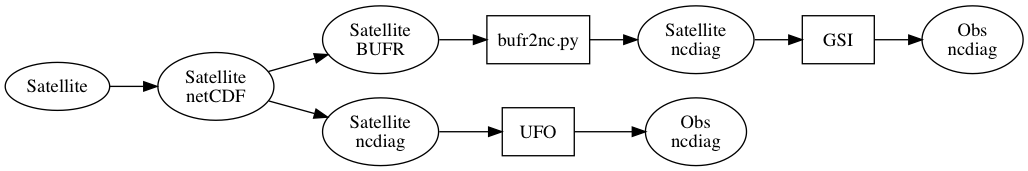

* Obs ncdiag in above diagram contains original obs plus interpolated model obs

# Notes, 3/7/18

* Great website for git flow:  
    http://nvie.com/posts/a-successful-git-branching-model/

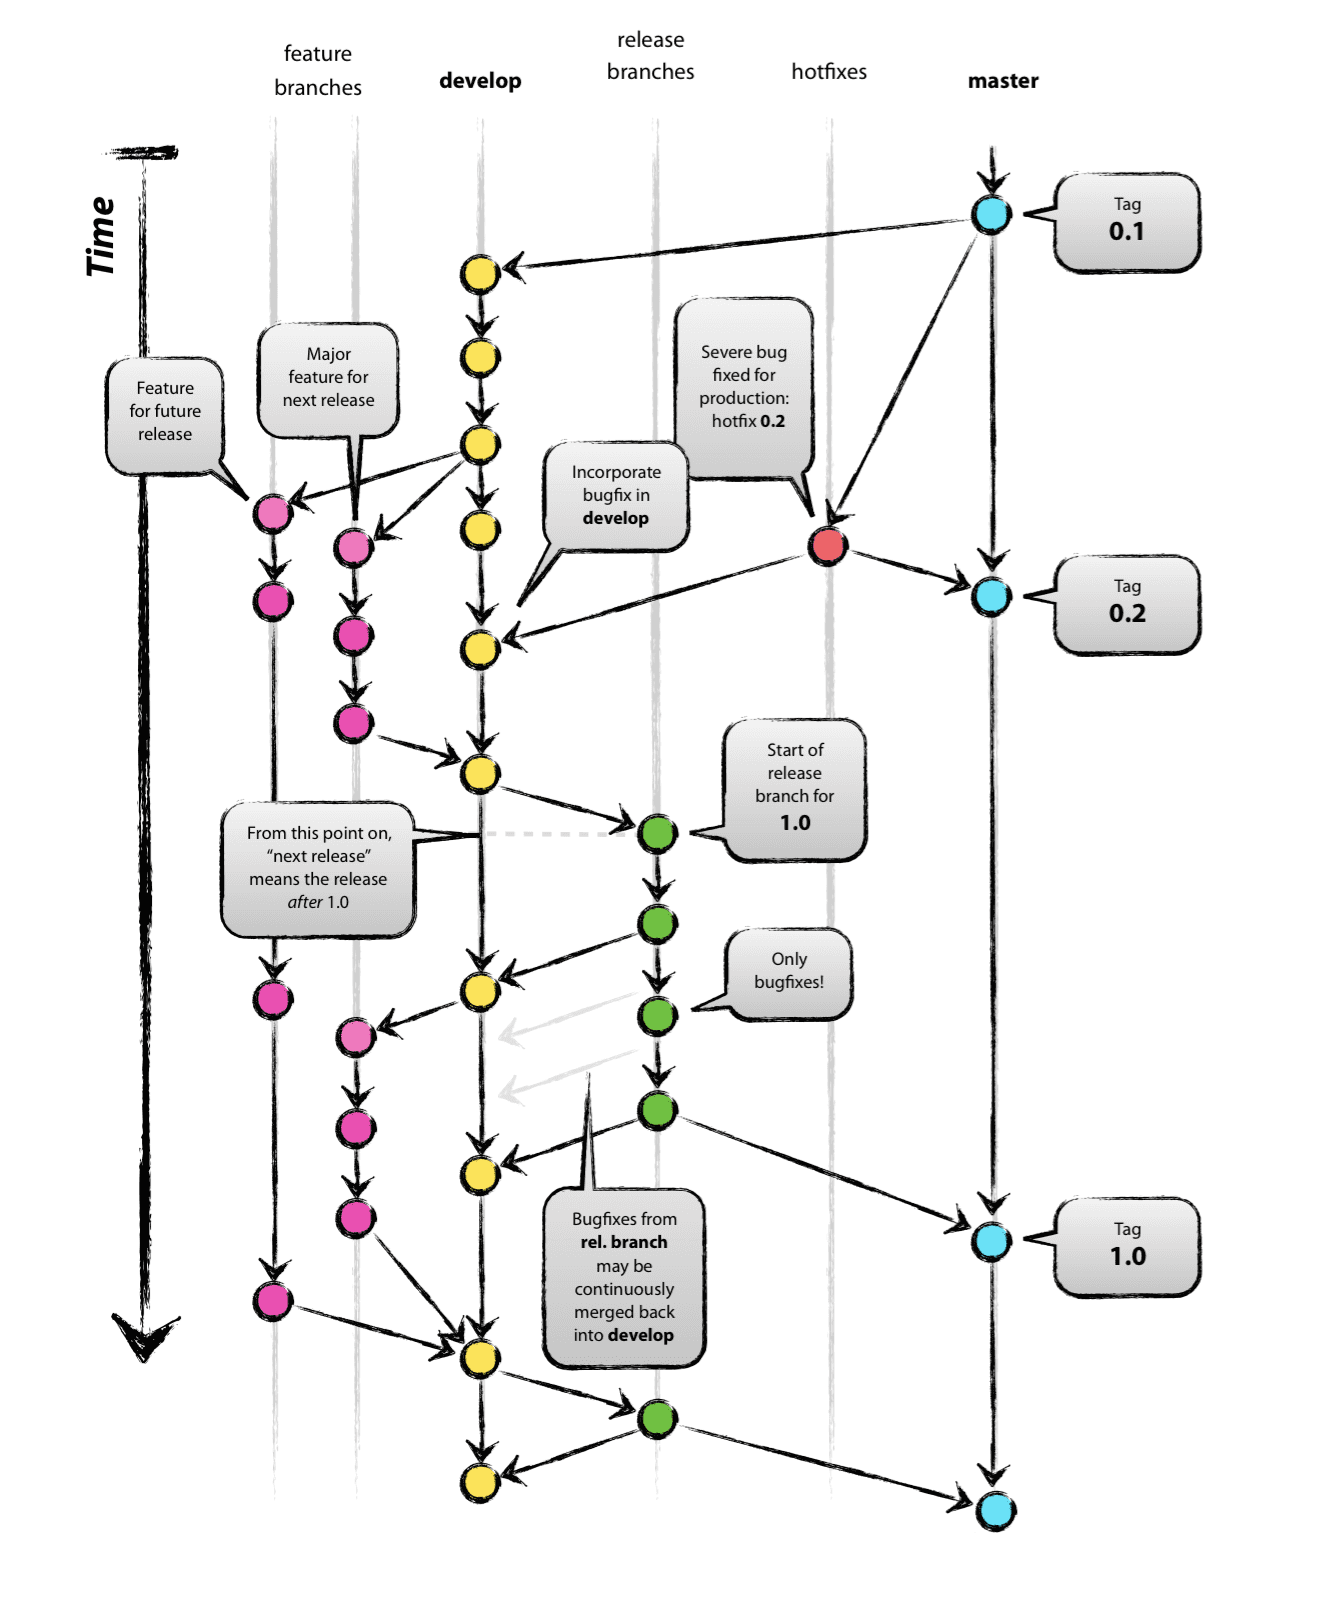

# Notes, 3/14/18

* Marek Wlasak was having problems building OOPS/MPAS in Singularity on his Mac
* GitHub repository: UCAR/mpas-bundle
* Has 4GB VM configured in vagrant (followed the directions on the wiki)
* Both Mark and I duplicated the fault
    * missing mpas_derived_types fortran module file
    * searched mpas code (from UCAR/mpas repo) and nowhere is this module defined
* Learned that byoung-joo (BJ) in NCAR has been recently working with MPAS
* BJ has his own formula for compiling mpas-bundle
    * build_mpas.csh script
        * this exists in UCAR/mpas repository in the develop branch
            * don't use the one in the master branch
    * builds MPAS using source code in a tarball: MPAS_Release.tgz
        * Creates an MPAS library
    * MPAS library from the tarball of MPAS source code is linked into mpas-bundle
        * UCAR/mpas source code is completely bypassed
* Tried build_mpas.csh on my iMac and it works
    * Sent instructions to Marek (and others) showing how I did this
    * ctest reveals two test failures out of 225 tests
        * Not sure if these are significant
* UCAR/mpas and UCAR/mpas-bundle eventually need to be updated with BJ's fixes

# Meeting, 3/15/18

## ReadTheDocs

* &#36;20/month small subscription
* Still cannot connect to private repo
    * Working with support, haven't heard back yet
* Need to have private repo and publish public docs
    * Private docs at first, then when ready public docs

## ncdiag

* BUFR to NC performance issue is fixed
    * Added option to limit number of messages to process
    * Reading events is the bottleneck
        * Unfortunately, GSI uses these
    * Sondes, Aircraft
    * Next step is to add in Radiance and GPSRO
* Clara is writing an ncdiag reader/writer for GSI (Fortran)
    * Mimicing read_prepbufr.f90
* After she finishes, will work on mergeing UFO and GSI reader/writers
    * Try to pull things into IODA such as the common ncdiag reader/writer
* Clara also is working on GPSRO reader for GSI
* Goal is to use GPSRO as first transfer to UFO flow
* Don't add any more obs types beyond GPSRO
* GPSRO
    * Francois (Boulder, NOAA) is in charge
* MET office - Exeter
    * ODB for obs data
        * Fortran, C++, Python APIs
        * More the file store, has database (SQL-like) capabilities
    * Investigate replacing netCDF with ODB
    * We can cooperate with MET office on development of integrating ODB into JEDI
        * Have a software engineer, 50% time
    * Prototype ODB solution in parallel with netCDF development
    * Machine learning capability(?)
        * Eg, TensorFlow
    * Go to Exeter for 1 week to train on ODB

## NICAS

* Part of assimilation function, not tied to a specific model
* Modeling background covariance matrix
* Uses MPI
* Not merged into OOPS develop track
    * OOPS has separate nicas tracks
    * Code not clean enough yet to merge into develop track

## Xin (processing aircraft obs)

* Distribution of observations across processes in MPI
* Trade off between load balancing and minimizing communication
    * Two extremes
        * Distribute obs to process subdomain that contains the location
            * This will minimize inter process communication
                * All model location information is on the same process as obs
            * This could end up with many obs on one process
                * Localized concentrations of obs (eg, where clouds exist)
        * Distribute evenly across all processes
            * This will increase inter process communication
    * Not clear how to optimize this problem
        * Machine learning(?)


# Team meeting, 3/21/18

* Tom: Ease of use is key to success

## MPAS

* Mike Duda - lead software engineer
    * Work with BJ, get MPAS into mpas-bundle repo
* Document current flow on wiki
    * Cut and paste my email instructions

## Documentation

* Urgent
* Will be using Sphinx
* Unclear how to publish
    * Yannick and Tom will see about where/how to publish
* Write a document about how to create docs with Sphinx
* ZenHub board for docs
* Meeting to plan who writes which documents

## JSON

* Original idea was to generate these files via a GUI
    * Have an example by the November release
    * Depending on Obs Type, Model, etc. the parameters to be filled in change
        * GUI could be programmed to present the appropriate parameter lists according to Obs Type, Model, etc.
* Currently, have to edit these files manually

## Amazon Cloud/Services

* Large data tests
* Buy license, import your own compiler
* Similar to container
    * Virtual machine
    * We can specify what's in the machine

## BUFR

* Stop adding Obs Types
* Current Obs Types
    * Aircraft
    * Sondes
    * GPSRO
    * Radiance
        * AMSU

## ncdiag

* Move reader/writer into IODA

## ODB

* MET office, Exeter
    * Training
    * Software engineer, 50% time to help us

* Go to Exeter after summer vacation
    * Go straight from Italy to England



# Team meeting, 3/27/18

## Documentation

* Distinction between Wiki and ReadTheDocs
    * Use Wiki for things that require discussion among the developers
    * Use ReadTheDocs for things that are fairly set
    
    * User and Developer docs can go into both areas
    
    * Users will tend to be developers but limited to minor changes
    * Developers are who we call co-developers (major changes)

* Review JEDI wiki
    * Where does each document belong? (Wiki or ReadTheDocs)
    * What needs updating?
    * Whan new pages are needed?
    
    * Can we export Wiki into a format that makes it easy to transfer to ReadTheDocs
        * markdown (?)

* Where to publish in the long run
    * Tom is looking into this
    * UCAR site?
    * Use ReadTheDocs in the meantime

* Forking work flow
    * Some entities will do development on their own, then will want to merge in changes
    * They will do an internal review before requesting the merge
    * They will use the methodology where you fork the repository, then do a pull request from the forked repository (to the main repository)
    * This methodology is being adopted to manage the potentially large number of user/developers


## MPAS

* Source lives at NCAR
* Ideally, we just point our mpas-bundle CMakeLists.txt file to the NCAR repo
    * Use the tag mechanism to freeze on desired versions
    
## Ocean model (SOCA)

* Guillaume Vernieres
* Sea ice obs type
    * Sea-ice model (CIC?)
* EMC (NOAA)
    * College Park
    * EMC is last step before handing off to operations

## UFO

* GPSRO is first obs type to port over to UFO flow
    * Francois
    * September, 2018
* GSI flow consists of two major pieces 
    * Observer
    * Downstream processing
* Initially, UFO will be in parallel with the GSI Observer piece
    * UFO will eventually cover the downstream processing too.

## IODA

* Need to find obs (BUFR) and model (initilization, background) files for JEDI Academy
    * Academy is in June, 2018
        * Roughly 20 attendees (co-developers)
    * Coordinate date for obs and model files
    * Jeff W. can help us select a good date
    * Obs data
        * Aircraft
        * Radiance (AMSU-A)
        * Radiosonde
        * GPSRO


# JEDI Weekly, 3/29/18

* Alternate each week between model and obs discussions
    * Except we will do model this week and next week

## GitHub

* Yannick has moved all repos from UCAR to JCSDA except for:
    * IODA
    * UFO
    * OOPS
    * CRTM

* Teams
    * Can have team discussions (like a chat room)
    * Top of GitHub page --> Teams --> Start discussion
    * See if these are useful

## Model "trajectories"
* When importing interpolated model data (GeoVaLs) into UFO, certain variables need to be transformed
    * Temperature is one of the tricky ones
        * Different models use different temperature types (potential, virtual, etc.)
        * Need to transform to straight Temperature (T) before comparing with obs
        * There is a non-linear relationship between model representation and T
    * Other vars are in the boat to0

* Ideally, want the model to send it's temperature data as T, not it's native tempurature type
    * This makes it so that the ObsOperator can be generic (always receives T)

* This is proving to be problematic however(MPAS, FV3, eg)

* With the entire set of vars that go through this transition, another sticky point is do you transform the varialbe before or after interpolating it?

* Long term, we want the model side to handle this transformation so that ObsOperator is generic
   * This will take too long to implement because of issues with the model side handling this task

* Short term, we will create derived classes of ObsOperator for each model that have methods for doing the transformations
   * This will get us going faster, and it's a fairly clean solution

## OOPS

* Want to sync up with ECMWF
    * Working on an agreement from management

* ECMWF version has differences
    * Model side - minor
    * Obs side - major

# Notes, 4/2/18

## JEDI wiki contents

* Where does each article in the JEDI Wiki belong?
* Simplified criteria
    * If it needs discussion among the team, it goes in the wiki
    * If it is fairly set (doesn't need discussion), it goes in ReadTheDocs

| Article | Sub Article | Action | Notes |
|:--------|:------------|:------:|:------|
| Docker and Singularity Quick Tutorial | | Delete/Archive | Have Singularity in ReadTheDocs, Docker is obsoleted |
| JEDI Introduction                     | | ReadTheDocs | Intro to philosophy |
| Working Practices and Governance for Collaborative Code Development | | ReadTheDocs | Overview of operating mode |
| Project Plans |                       | Wiki | How we plan to get the work done for the major pieces of the system |
| | Work Plan for Infrastructure        | Wiki | |
| | Work Plan for Abstract Layer        | Wiki | |
| | Work Plan for Interpolations        | Wiki | |
| | Work Plan for Observation Operators | Wiki | |
| | Work Plan for IODA                  | Wiki | |
| Infrastructure |                        | Wiki | Tasks, Meeting Notes, Planning |
| | Exchanging code between EMC and JCSDA | Wiki | |
| | Using BitBucket and JIRA              | ReadTheDocs | Update to Using GitHub and ZenHub |
| Abstract Layer | | Wiki | Tasks |
| | Abstract UFO   | Wiki | |
| Interpolations |           | Wiki | Tasks |
| | Interpoloations Meetings | Wiki | |
| Observations Operators |                 | Wiki | Tasks, Meeting Notes, Planning |
| | GSI Observation Operator               | Wiki | | 
| | Interfaces for Aircraft Observations   | Wiki | |
| | Marine UFO Hackathon, (May 7-18, 2018) | Wiki | |
| | November 2017 Hackathon                | Wiki | |
| | Observation Operators Meetings         | Wiki | |
| Interface for Observation Data (IODA) | | Wiki | Tasks, Meeting Notes, Planning |
| | IODA Meetings                         | Wiki | |
| | IODA v0                               | Wiki | Out of date: Using bufr2nc GitHub repo now |
| Fortran Interfaces for JEDI |                    | Wiki | Attaching existing Fortran code to C++ system |
| | Model Space Fortran Interface                  | Wiki |   These might belong in ReadTheDocs           |
| | Observation Space Fortran Interface            | Wiki | |
| | Other Fortran Data Interfaces                  | Wiki | |
| | Model Fortran Interfaces                       | Wiki | |
| | Observation Operator Fortran Interface         | Wiki | | 
| | Error and Error Covariances Fortran Interfaces | Wiki | | 
| How to Articles |                                    | ReadTheDocs | Various topics |
| | Build JEDI Environment with Docker                 | ReadTheDocs | Obsolete |
| | Build JEDI Environment with Singularity            | ReadTheDocs | Merge with other Singularity articles |
| | Docker development environment for GSI and FV3     | ReadTheDocs | Either obsolete or rewrite for Singularity |
| | How to use JEDI bundles                            | ReadTheDocs | |
| | Obsolete                                           | Delete/Archive | |
| | Temporary flow for compiling mpas-bundle           | ReadTheDocs | |
| Adding Models into OOPS/JEDI | | ReadTheDocs | More how-to articles |
| | Interfacing FV3GFS           | ReadTheDocs | |
| | Interfacing LFRic            | ReadTheDocs | |
| | Interfacing MOM5/CICE        | ReadTheDocs | |
| | Interfacing MPAS             | ReadTheDocs | |
| | Interfacing WRF              | ReadTheDocs | |
| File list | | Delete/Archive? | Looks like an netcdf reader - perhaps belongs in IODA repo |
| Software Development Methodology |  | Wiki | Results of research into software development tools |
| | Agile project management software | Wiki |   Documents on how to use the tools we select belong on ReadTheDocs |
| | Documentation Tools Options       | Wiki | |
| | Getting Started with ZenHub       | ReadTheDocs | |
| JEDI code branches | | Wiki | Tables showing owners of different repos and whos working on which branches |

# Team Meeting, 4/3/18

## IODA

* I move IODA repo to JCSDA
    * Xin has a pull request to process before the move
    
* Send Xin complete obs files for Aircraft
    * He is using only T for now
    * Xin's next task is to do multiple obs for Aircraft
    * Reader in ioda is not capable of storing multiple obs
        * Has just one variable called "Observations"

* AOD is on hold for now
    * Need to continue supporting Mariusz
    * Yannick will talk with Mariusz to see if he is okay, or we need to add AOD

## Academy

* June 4-8, 2018

* Center Green (NCAR/UCAR)
    * Near Foothills lab

* What example cases do we want?
    * Need to discuss with
        * Dan (FV3)
        * Rahul (FV3)
        * Anna
        * Clara
        * Jeff

* Simple plotting utilities would be nice so participants can visualize data

* Review Yannick's list of activities
    * Let him know if there is something you want to teach

## Documentation

* Kyle no longer works with JCSDA
    * Melanie Russ is a contact
        * Not sure she's the replacement, but can direct us to that person
        * Mark sent an email asking for help

## Misc

* Rudy has transferred to UCAR IT

* Whitney is still in JCSDA
    * On vacation this week

* Trajectory
    * Refers to a "linearized state"
    * Term comes from modeling world
    * Yannick will send link to a tutorial about creating a linearized state
    

# JEDI Weekly, 3/5/18

## Updates on obs types
* Radiosonde, Radiance
    * Dan
    * Reorg of ufo source code
    * Put in hooks to Jacobian operator

* Marine
    * Guillaume
    * Sea ice fraction
    * Sea ice thickness
    * Steric height
    
    * Don't need BUFR to ncdiag conversion for these now (but will need these later)

* Aircraft
    * Xin
    * Issue with obs types
        * Not sure what he is talking about
        * Yannick suggesting using an OO approach with base and subclasses

* AOD
    * Mariusz

* GSPRO
    * Francois
    * GSI branch for gpsro
    * First stage is to handle "GS1" (?)

## Obs Operators

* Six total
    * Finish these before adding more

## Misc

* Need to provide full obs set (T, q, u, v) in ncdiag files
    * Make sure we can do all of the above variables

* Guillaume has a list of issues for UFO that he wants to put in ZenHub

* Start with CF conventions for ncdiag

* Singularity is available on Discover (NASA)


# JEDI Core, 3/11/18

## Obs check for IODA reader

* For random obs initialization, throw out obs not in the time window
* For normal flow, don't need to do this since upstream has already filtered on the time window
* Multiprocessor throws in another twist for random obs initialization
    * Random locations
    * If all locations are in one subdomain (one process), then load balance is not good
* Xin has some code for the random initialization filtering
    * Round robin for assigning obs to multiple processors

## Misc

* Mark will organize a meeting to determine which date/time we should use for JEDI Academy exersizes
    * Need to have same date/time for model files and obs files
    * Attendees: Dan, Clara, Anna, Jeff, BJ, Core Team, Rahul


# JEDI Weekly, 4/12/18

## IODA

* Should we consider multiple file formats?
    * This is an important decision
    * Need to establish a solid file interface first
        * Stay with this interface
        * Allows us to change/add file formats

* Need to go with one memory store format
    * ODB looks good for this
        * Already supports MPI, large data

* Jun, 2018: netcdf, ODB prototypes

* Sep, 2018: Workshop to go over IODA file store

## ODB

* Met office is ready to have someone looking at ODB in 1-2 weeks

## Repos

* OOPS is last repo to make the move from UCAR to JCSDA
    * Plan to do the move next week

* Eckit, fckit, and ecbuild repos will go away from JCSDA
    * ECMWF now provides public access to these repos
    * No need for us to keep our own copies
    * We can checkout based on release tags
        * Only move tags when we are ready
    * We can pick up a fix from ECMWF for an issue in our copy where eckit was recompiling unnecessarily


# ESMF presentation, 4/13/18

* NEMS (NOAA Environmental Modeling System)
    * Coupled model system
    * Integrating FV3 (and others) now
        * Currently using older models

* JEDI may be interested in:
    * Grid Remapping
    * Coupled DA

* Fortran, Python, partial C APIs
    * C API is fairly complete in the regridding area
    * No C++ API

* Light weight wrappers around model code

* Supports MPI, Pthreads

* Package is already installed on Theia

## NUOPC

* Interoperabilty Layer
* Can couple an atmospheric with an ocean model, for example
* Generic system
    * NEMS is a specific (to EMC) configuration of NUOPC

### Components

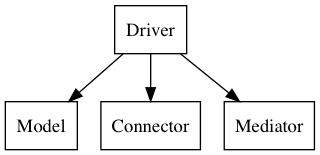

* Model
    * Initialize, run, capture output from a model
        * Atmos, ice, ocean, surface, etc.

* Connector
    * Communication between Model and Mediator
    * Handles parallelism, copies (if needed), etc.

* Mediator
    * Handles data transformations that may be necessary to pass data between models
    * Flux calculations (e.g. surface fluxes), averaging, etc.

* A hierarchical structure can be formed by nesting a Driver inside another Driver

### netcdf

* Using CF conventions to the degree that they can

* CF is not quite amenable to the coupling function
    * Probably have some variables that are not included in the CF convention


# JEDI Core Team, 4/17/18


## Upcoming JEDI meetings

### JCSDA Workshop, May, Boulder

* Science and technical aspects

* Register for this (Yannick will forward email)

* It's open for us to present
    * 15 to 20 minutes
    * Good for us to talk about Git Flow, GitHub, etc.
        * Show how system operates
        * Community tool aspect

### JEDI Academy, June 4-8, Boulder,

* Collaborators

* All of us will run this

### JEDI Summer School, August, Montana State

* Mark and I attend
    * DA training

* Mark and I present
    * Community tool

## IODA

* Three netcdf files
    * GoeVaLs
    * Obs from GSI
    * Obs from bufr2nc
    
    * Currently radiosonde has two files (UFO repo in testinput directory)
        * GeoVaLs
        * Obs from GSI
    
    * We want all obs types to be like radiosonde example
        * We will eventually get rid of the GeoVaLs file
            * This transfer will be in-memory
        * We will want to keep the Obs file
            * Input to the UFO flow

* Representation of time
    * In UFO memory, we want absolute time in UTC
    * bufr2n

## Notes

* How to see all issues assigned to yourself
    * GitHub -> at top hit "Issues" -> "Assigned"

* Git LFS
    * Standard git clone commands will work
    * But still have to install git-lfs package

* Continue with JEDI intro and JEDI governance imports
    * Yannick will write an intro for hte Wiki

* Assume everyone is using Singularity (instead of Docker)

* GeoVaLs
    * Profiles that result from interpolating model fields
        * Interpolated to horizontal location of obs
    * For testing, we read GeoVaLs from a netcdf file that GSI writes
        * This avoids having to run GSI for downstream tests
    * We need an aircraft version of GeoVaLs

* Single precision got added to GeoVaLs reader (UFO repo), but not to the readers stored in IODA repo.
    * These may be okay, but need to be checked

* Date for obs and model files that go into sample UFO flows
    * April 15, 2018, 00Z
    * Update test data in repos to this date (git-lfs)



# JEDI Core Team, 4/24/18

* With C++ templates, the compiler only compilers versions for the types that are instantiated
    * Not all types get compiled as a result
    * There could be a bug that gets exposed when a new type is introduce

* Configuration objects
    * We need to standardize a naming convention for config files
    * Currently using JSON, but would be better to switch to YAML
        * YAML allows for comments
        * The existing parser can handle both JSON and YAML
    * System is set up where you cannot modify the "global" configuration
        * The parser creates the "global" configuration
        * Protection against accidental modification
        * There is a facility to copy the global config into a "local" config
            * The local config can be modified
        * Use the local config mechanism when needing to modify the global config

* Obs file
    * Only I need the BUFR files
    * Convert to netcdf
    * Everyone needs access to the netcdf files
    * Create two sets of netcdf
        * Small: thin out the obs, use for unit test, put in GitLFS
        * Large: all obs, use for system test, put in Amazon cloud
    * Put the obs unit test files in UFO

* Build on Cheyenne
    * Check with Chris on how he built UFO on Theia
    * Look at examples
        * JCSDA/mpas
        * JCSDA/fv3

* Fortran "implicit none" issue
    * Look at ReadTheDocs
        * C++, Google style guide, script to check style: cpplint
        * Need same thing for Fortran
            * Don't know of script like cpplint for Fortran


# JEDI Academy Planning, 4/24/18

## Audience

* Most people know DA
* Mix of experience with Fortran/C++
* Target audience is developers
* Will be using laptops
    * Send instructions 2-3 wks prior on how to install Singularity
    * Fix the slots issue on Mac

## Practicals

* We will use FV3 for inital demo (Dan)
    * Scripted up so it's push-button
* Primary demo/practical is UFO
    * Add a radiosonde obs type, plus a test
    * Work from template files
        * Fill in 
        * Use another obs type as a guide
    * Start with a copy of the repo with radiosonde missing
    * Create the templates from the existing radiosonde files
        * Just delete the stuff that the students are to fill in
        * C++: ObsOperator, ObsOperatorTLAD
        * Fortran: ObsOperator, interfaces (C++ to Fortran), empty methods, ObsSpace, Fortran.h
* I will test the UFO radiosonde practical
* Mark will test the model practical (FV3?)

## Talks

* Use a JCSDA powerpoint template for our talks
    * Yannick will supply
* My talk
    * ObsSpace
        * Object that is created by the IODA reader
    * netcdf
        * Don't talk about geovals file since this is only for testing

## Misc

* Next meeting in 3 weeks
    * Outline of our talks
    * Pass these around beforehand so people can review and bring comments to the meeting
* Docs
    * Do cmake, ctest, ecbuild doc next

# JEDI Core, 5/1/18

* Shoot for week of July 9 for travel to UKMO

## Compilers

* Support these compilers
    * GNU
        * Version 6 or newer (need c++11 standard)
    * Intel
        * Latest version - 18
    * Cray
    * IBM
    
* Cray and IBM are on the list since some of the operations centers use these

* GNU, Intel are for collaborators

* Intel for HPC systems

## MPI

* eckit MPI wrapper
    * Chris is looking at extending to C++

* Currently, using only the Fortran MPI interface

* Want to use MPI at C++ level
    * Do ensemble runs in parallel
        * OOPS would create an MPI communicator for each model, and one for processing model output

* Support these libraries
    * MPICH
    * OpenMPI
    
    * IBM, Cray - if they have their own flavors of MPI

* Using mpicc, mpicxx, mpifort in subsequent compiles
    * ecbuild will handle what the these wrappers typically do
    * Stay with ecbuild since this is the same for any MPI system (simpler)

## OOPS

* Everthing that doesn't require NICAS should branch from the develop branch
    * NICAS is required by non-toy models: FV3, MPAS, eg.
    * NICAS work should branch from the nicas-develop branch

* Currently, we are merging develop into nicas-develop

* Plan is to eventually merge nicas-develop into develop and work with one develop branch
    * The nicas-develop code needs to get cleaned up first
    * Is there someone we know who could get hired for 1-2 months to do this project?

## IODA/UFO

* Move ObsSpace related code into IODA

* Keep ObsOperator related code in UFO

* Xin is working on refactoring duplicated ObsSpace code
    * Want this fixed for the JEDI Academy
    * Coordinate this with my reader work


# JEDI Core, 5/8/18

## ObsSpace

* Only observational data, no model data (geovals)

### OOPS

* Abstraction of interface only
    * Implementation is in UFO and IODA
    * UFO pieces need to move into IODA

* src/oops/interface/ObservationSpace.h
    * obsdb\_ is pointer into any kind of implementation of an ObsSpace
        * typedef typename MODEL::ObsSpace ObsSpace\_
            * MODEL gets replaced with "ufo" so this becomes type ufo::ObsSpace
        * boost shared\_ptr\<ObsSpace\_\> obsdb\_
            * obsdb\_ is pointer to ufo::ObsSpace object
    * MODEL is template that can be set to any kind of implementation
        * ufo, ioda, odb, etc.

### UFO

* src/ufo/ObsSpace.h
    * Implementation of the OOPS interface
    * Has a corresponding ObsSpace.cc
    * F90odb keyOspace\_
        * F90odb is an integer
            * Serving as a pointer
            * Used to index into an obs type registry
                * Radiosonde has a "radiosonde" registry
                * Registry is just a linked list with pointers to the data structures holding the obs values

## Misc

* Three branches of NOAA that fund us
    * OAR (Oceanic and Atmospheric Research)
    * NWS (National Weather Service)
    * NESDIS (National Environmental Satellite, Data, and Information Service)
        * Operational satellites
        * Obs data (BUFR)

# JEDI Core, 5/15/18

## IODA

* Code duplication
    * Clean up duplicated code - Now
    * Decide on file format - September

* JEDIAcademy branch has April 15, 2018 00Z model data

* Tasks
    * Switch to April 15 obs data - Steve
    * Read T,u,v,q,... into ObsSpace - Steve
    * Remove duplicated code - Xin
    * Use T,u,v,q,... in ObsOperator - Xin

## Misc

* How do we monitor memory usasge across C++, Fortran interface?
* Need to improve
    * Memory usage monitoring
    * Run time monitoring


# JEDI Academy planning, 5/15/18

* Approximately 25 people attending (number includes us)

* Repeat academy in College Park 1st or 2nd week of December
    * Don't want to conflict with AGU Meeting

* All attendees need to prepare before academy starts
    * Singularity
    * fv3-bundle
        * Download
            * Need to get files onto their laptops since this takes a long time
        * Optionally try to compile and test
    * Dan and Mark will prepare and send out an email to everyone

* Presentations
    * For ObsSpace, Yannick will handle the OOPS side and I will do the IODA side
    * 30 - 45 minutes per talk
    * Send out estimate of time for talk to everyone by next week
    * Yannick will send out a powerpoint template slide

* Steps
    * Prepare slides - Everyone
        * Mine are for IODA talk, and intro to Thursday practical
    * Send email to everyone asking to prepare - Mark
    * Anna will send me the obs type practical
        * I will take it for a trial run

# JEDI Core, 8/21/18

* BUMP
    * develop-bump will bet merged into develop in OOPS
    * develop-bmatrix will also get merged
        * Doesn't work with Intel compiler
        * Mark will look into this
    * Benjamin M (Meteo-France) will join our team
        * Math background
    * Code needs cleanup
        * Move interp routines to utils
        * Move random number generator to utils
            * Supposed to be platform independent
    * Clean up interface
    * KD tree to distribute across processors
        * In Fortran
        * Might be nice to move to C++ so we can leverage (eg, Obs distribution)
        * Basic idea of KD tree is to work on sphere and chop up according to lats, lons
            * Cut along a lat (two pieces)
            * Then along a lon (four pieces)
            * Cut along a lat (eight pieces)
            * Continue alternating between lat and lon cuts

* Code sprint (GNSSRO)
    * One week: Aug 27 - 31
    * Provide help as needed
    * Developing the 2D obs operator

* MPI
    * Chris has fixed it so that eckit will present some data via C++ and Fortran

* ODB
    * Dale Barker from UKMO is here this week
    * Met office will apply pressure to ECMWF to make ODB1 available
    * By mid-September we should know

* Intel compilier for Mac
    * Rahul has been investigating
    * .edu organizations can get a free version (might be limited to one month)
        * Might be worth buying one or two licenses, but probably too much to get a license for everyone
    * Amazon might be able to provide access
        * Would cost something, but maybe we can share

# JCSDA all hands, 10/9/18

* Operating plan (AOP)
   * Google docs, waiting for one signature
   * Part 1: this year
   * Part 2: 5 years out

* Slide with personnel, shows who is core team, who is contributors, etc.

* Quarterly review, Oct 16th

* Symposium, Jan 2019 @ EMS

* Executive Team, Feb 2019
    * AOP ready by April 1, 2019

* All-hands, April, 2019
    * Kick off new AOP

* Science workshop, May, 2019
    * NASA host

# JEDI Academy, 10/15/18

* 60 people
* 4 days
* EMC, GMAO (~50)
* level will be lower than before
    * First part (3 days): Fortran, basics
    * Second part (1 day): C++, Classes, Model interface, advanced
* practical
    * Very simple
    * 3DVar may be too much
    * Run in cloud?
    * Tar file for Theia, Discover; use modules to control environment
    * Split into groups, have a repo for each group, within group have developer, reviewer, etc.
    * Have practical go though entire design loop using git, github, git flow, etc.
* many people don't have laptops
* Yannick will send out slides on the "integer instead of pointer" Fortran implementation
    * Only reason we don't use pointers is due to a defect in the Cray compiler
        * Can't deallocate a pointer where the object is in Fortran and the pointer was given to Fortran through C++
            * Going through the C++ layer strips off the metadata that guides the deallocate in Fortran
* Doxygen
    * Pre-built website in cloud
    * Give this to people at start
    * Intro to docs at beginning of academy
* IODA presentation
    * Show Conceptual view
    * Show Fortran interface
    * No details about implementation
* QC needs to be discussed
    * Maybe use QC as practical
* EMC
    * Wants to see functionality
    * We want to push the methodology

# JEDI core, 10/16/18

* Next week code sprints
   * Dan will be on site
   * 4DVar, FV3 will be primary focus
   * GNSSRO issue with pressure
      * obs op wants to modify pressure, but pressure is coordinate for some models

# JEDI core, 10/23/18

* Academy
    * Practical
        * obs operator - start with one variable, then add u,v
        * First day
            * Amazon machines for each group
            * ecbuild, make, ctest, run an app (3Dvar)
            * make a feature branch
        * Second day
            * Add u,v to obs operator (Radiosonde)
            * Modify test (expected result)
        * Third day
            * Do a QC filter exercise

# JEDI core, 10/30/18

* GCC compiler bug
    * Shows up in 7.2
    * Seemed to be exposed when latest BUMP changes were merged in
    * Compiler gets internal error during the "finalize" step
    * David D. came up with workaround to compile a dummy file as a last step
        * Makes the finalize step happy
    * Dan noticed that 8.2 works in debug mode, but fails in optimization mode
        * Dan will look at 7.3

* Benjamin will want to merge in BUMP updates soon

* Xin has radiosonde and aircraft working with C++ ObsSpace

* After the Academy, get clang on Mac working

* Mark
    * github accounts working (15)
        * can access with just an SSH key
        * no need for AWS accounts
        * accounts 16-20 are currently blocked by github (working on getting these unblocked)
    * will work on scripts to make setup and cloning easier
    * fv3-bundle is still having test failures (hofx, 3dvar,...  geos and gfs) on the Amazon platform
        * once the fv3-bundle tests pass, create an AMI that contains fv3-bundle

* All of us need to go through instructions for Amazon usage before the Academy

* 58 people are signed up for the Academy